# Iris flower prediction

In [1]:
import pandas as pd                                    # for loading dataset
import numpy as np                                     # for numerical computation
from matplotlib import pyplot as plt                   # visualize tool
import seaborn as sns                                  # visualize tool

from statsmodels.stats.outliers_influence import variance_inflation_factor  # to calculate VIF

from sklearn.model_selection import train_test_split  # to split data into train and test sets
from sklearn.model_selection import GridSearchCV      # to perform hyper-parameter optimization
from sklearn.svm import SVC                           # SVC(Support Vector Classifier) object

from sklearn.preprocessing import StandardScaler      # to perform normalization
from sklearn.metrics import confusion_matrix, plot_confusion_matrix   # to draw confusion matrix
from sklearn.metrics import classification_report      # breif report about SVC model
from sklearn.metrics import roc_curve, auc         # to draw ROC and calucate AUC Score

from sklearn.model_selection import cross_val_score  # to perform cross validation

import joblib  # to save SVC model for deployment purpose

# Loading Dataset

In [2]:
df = pd.read_csv('data/Iris.csv', index_col='Id')
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
df.dtypes

SepalLengthCm    float64
SepalWidthCm     float64
PetalLengthCm    float64
PetalWidthCm     float64
Species           object
dtype: object

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 1 to 150
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 7.0+ KB


In [5]:
df.shape

(150, 5)

# Checking for missing values

<AxesSubplot:ylabel='Id'>

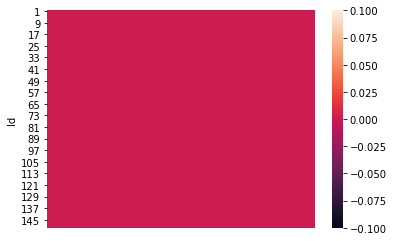

In [6]:
sns.heatmap(df.isnull(), xticklabels=False)

We can confirm that there are no nan values. Meaning No missing value, that is good for us because we don’t need to impute those missing values or dropping them.

# checking for multi-collinearity

<AxesSubplot:>

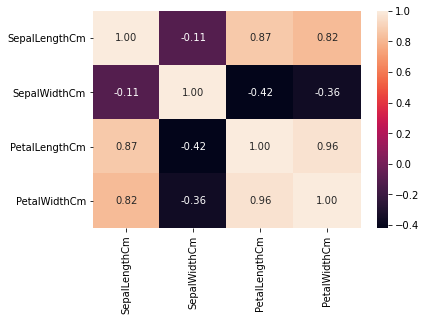

In [7]:
sns.heatmap(df.corr(), annot=True, fmt='.2f',)

There are some features that are highly corelated with each other, like sepalLength and PetalLength (pearson correlation coefficient = **0.87**).  Same with PetalLength and PetalWidth (pearson correlation coefficient = **0.96**).  And with PetalWidth and SeptalLength (pearson correlation coefficient = **0.82**)

In [8]:
def vif_scores(df): #calculating VIF scores for dataSet
    VIF_Scores = pd.DataFrame()
    VIF_Scores["Independent Features"] = df.columns
    VIF_Scores["VIF Scores"] = [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]
    return VIF_Scores

In [9]:
vif_scores(df.iloc[:, :-1])

,Independent Features,VIF Scores
0,SepalLengthCm,264.745711
1,SepalWidthCm,97.111606
2,PetalLengthCm,173.968965
3,PetalWidthCm,55.488689


With high VIF values (>10) multi-collinearity exist in data.

Because we are going to use SVM so we are not doing anything to remove multi-collinearity

# Visualizing Data

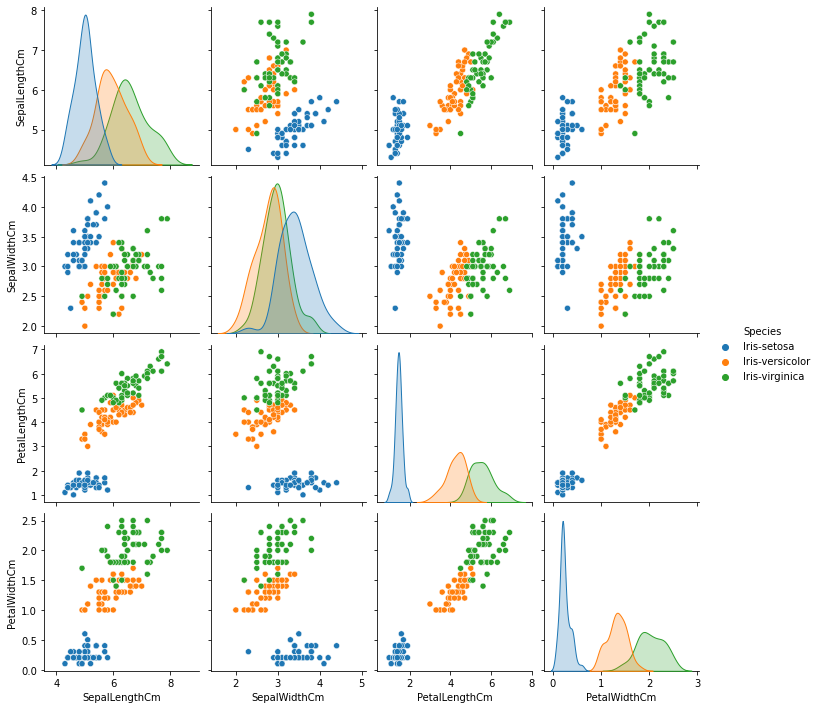

In [10]:
sns.pairplot(data=df, hue='Species')

## checking for imbalance data

<AxesSubplot:xlabel='Species', ylabel='count'>

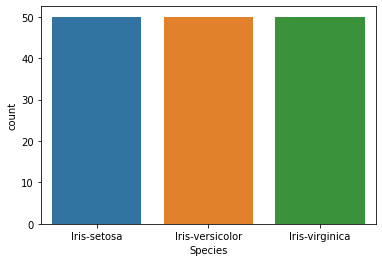

In [11]:
sns.countplot(x ='Species', data=df)

We have equal no of counts of each class (33.33% each). Not imbalance data.

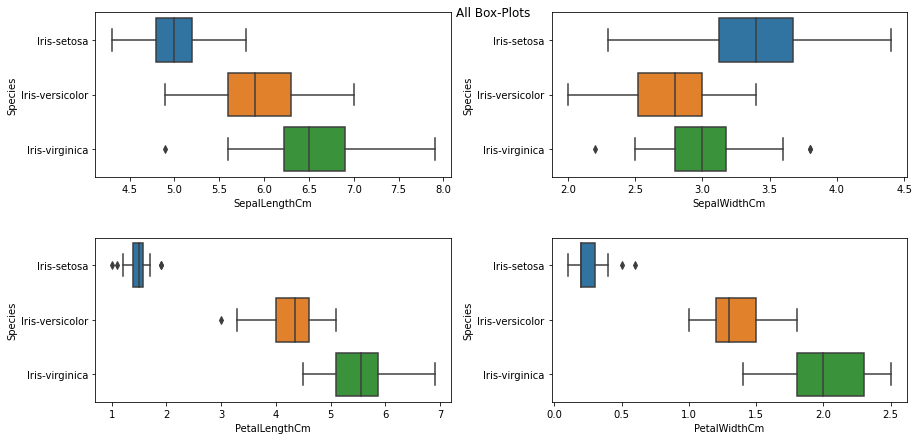

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
fig.tight_layout(h_pad=4, w_pad=7)
plt.suptitle('All Box-Plots')

for i in range(2):
    for j in range(2):
        index = 2*i +j
        sns.boxplot(y='Species', x=df.iloc[:, index], data=df, ax=ax[i, j])
plt.show()

There exist few outliers in data. Majority in 'PetalLengthcm'. So SVM can be a good choice because SVM don't get affected by outliers, unlike (KNN). 

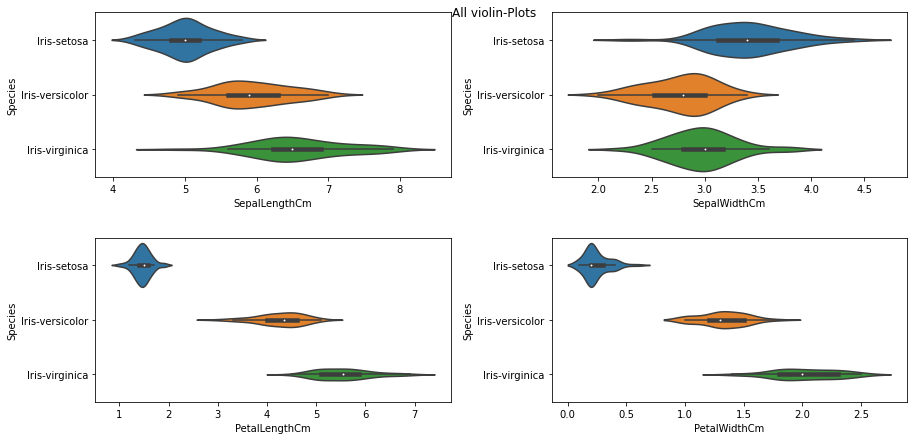

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
fig.tight_layout(h_pad=4, w_pad=7)
plt.suptitle('All violin-Plots')

for i in range(2):
    for j in range(2):
        index = 2*i +j
        sns.violinplot(y='Species', x=df.iloc[:, index], data=df,ax=ax[i, j])

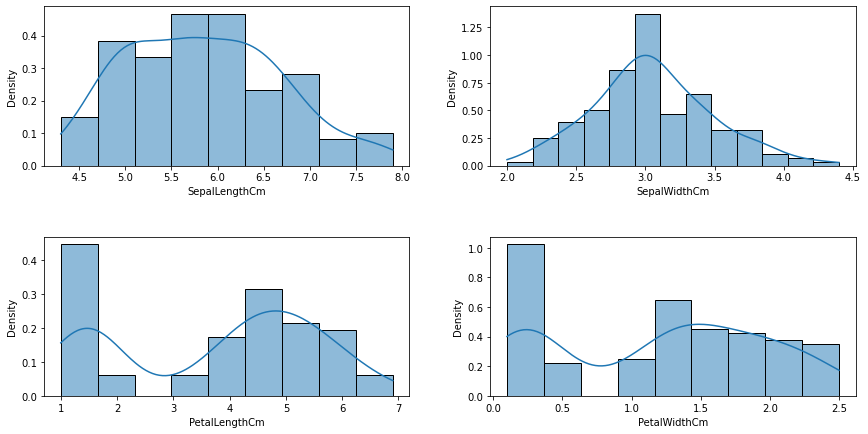

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
fig.tight_layout(h_pad=5, w_pad=5)


for i in range(2):
    for j in range(2):
        index = 2*i +j
        sns.histplot(df.iloc[:, index], ax=ax[i, j], kde=True, stat="density")

## Peparing Data for SVM

In [15]:
unique_types_i = df['Species'].unique()
unique_types = [x.replace('Iris-', '') for x in unique_types_i]
unique_types

['setosa', 'versicolor', 'virginica']

In [16]:
mapper = {unique_types_i[x]:x for x in range(len(unique_types))}
mapper

{'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

### classifing multi-class target

In [17]:
df['Species'] = df['Species'].map(mapper)
df['Species'].unique()

array([0, 1, 2], dtype=int64)

### Dividing Data into X(independent variables) and y(dependent variable)

In [18]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

## Spliting Data into train and test split 
___
default train set = 70% of data and test set = 30% data

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Normalizing Data

In [20]:
scale_obj = StandardScaler()

In [21]:
scale_obj.fit(X)
X_train_scaled = scale_obj.transform(X_train)

In [22]:
X_test_scaled = scale_obj.transform(X_test)

we are scaling features with training set to avoid data-leakage

# Applying SVM
___
Default hyperparameter means C=1.0, kernel=rbf and gamma=auto among other parameters

In [23]:
clf_svm = SVC()
clf_svm.fit(X_train_scaled, y_train)

SVC()

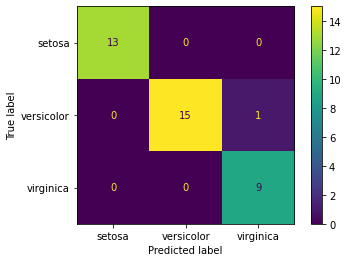

In [24]:
plot_confusion_matrix(clf_svm, X_test_scaled, y_test, values_format='d',
                      display_labels=unique_types)

In [25]:
y_pred = clf_svm.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.94      0.97        16
           2       0.90      1.00      0.95         9

    accuracy                           0.97        38
   macro avg       0.97      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38



Out of the box SVC perform very well with avg_accuracy 97%. Let's still do hyper parameter opmization to see if we can improve model more.

precision, recall, f1-score there value should be close to 1. 0 is worst and 1 is best.

# ROC-AUC
___
#### ROC Curve


Another tool to measure the classification model performance visually is **ROC Curve**. ROC Curve stands for **Receiver Operating Characteristic Curve**. An **ROC Curve** is a plot which shows the performance of a classification model at various 
classification threshold levels. 

**ROC AUC** stands for **Receiver Operating Characteristic - Area Under Curve**. It is a technique to compare classifier performance. In this technique, we measure the `area under the curve (AUC)`. A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. 


So, **ROC AUC** is the percentage of the ROC plot that is underneath the curve.

In [26]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:0.2f}) for {unique_types[i]}')
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

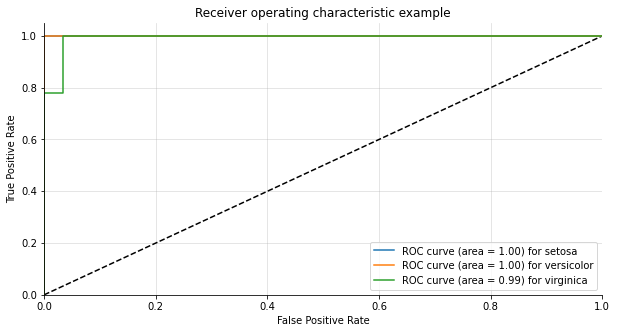

In [27]:
plot_multiclass_roc(clf_svm, X_test_scaled, y_test, n_classes=3, figsize=(10, 5))

- ROC AUC is a single number summary of classifier performance. The higher the value, the better the classifier.

- ROC AUC of our model approaches towards 1. So, we can conclude that our classifier does a good job in classifying the pulsar star.

# k-fold Cross Validation (with rbf and linear kernel)

### using linear kernel

In [28]:
linear_svc=SVC(kernel='linear')

linear_scores = cross_val_score(linear_svc, X, y, cv=10)
print(f'Linear Score (k=10)\n {linear_scores}')

Linear Score (k=10)
 [1.         0.93333333 1.         1.         0.86666667 1.
 0.93333333 1.         1.         1.        ]


In [29]:
print(f'Avg Linear K-Fold score = {np.mean(linear_scores) * 100 :0.4f}')

Avg Linear K-Fold score = 97.3333


### using rbf kernel

In [30]:
rbf_svc=SVC(kernel='rbf')

rbf_scores = cross_val_score(rbf_svc, X, y, cv=10)
print(f'rbf Score (k=10)\n {rbf_scores}')

rbf Score (k=10)
 [1.         0.93333333 1.         1.         1.         0.93333333
 0.93333333 0.93333333 1.         1.        ]


In [31]:
print(f'Avg rbf K-Fold score = {np.mean(rbf_scores) * 100:0.4f}')

Avg rbf K-Fold score = 97.3333


I obtain higher average k-fold cross-validation score of 97.33% with linear kernel and 97.33% with rbf kernel too

# Applying HyperParameter Optimization using GridSearchCv

In [32]:
param_grid = [ {'C':[0.25, 0.5, 1, 10, 100, 1000], 'kernel':['linear']},
               {'C':[0.25, 0.5, 1, 10, 100, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
               {'C':[0.25, 0.5, 1, 10, 100, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]} 
              ]


optimal_params = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy',verbose=0)

optimal_params.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [0.25, 0.5, 1, 10, 100, 1000],
                          'kernel': ['linear']},
                         {'C': [0.25, 0.5, 1, 10, 100, 1000],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                    0.9],
                          'kernel': ['rbf']},
                         {'C': [0.25, 0.5, 1, 10, 100, 1000],
                          'degree': [2, 3, 4],
                          'gamma': [0.01, 0.02, 0.03, 0.04, 0.05],
                          'kernel': ['poly']}],
             scoring='accuracy')

In [33]:
print('GridSearch CV best score : {:.4f}\n\n'.format(optimal_params.best_score_))

print('Parameters that give the best results :','\n\n', (optimal_params.best_params_))

GridSearch CV best score : 0.9640


Parameters that give the best results : 

 {'C': 0.5, 'kernel': 'linear'}


# Apply best params

In [34]:
clf_svm = SVC(**optimal_params.best_params_)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=0.5, kernel='linear')

In [35]:
clf_svm.score(X_test_scaled, y_test)

0.9736842105263158

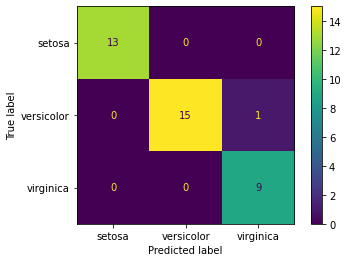

In [36]:
plot_confusion_matrix(clf_svm, X_test_scaled, y_test, values_format='d',
                      display_labels=unique_types)

In [37]:
y_pred = clf_svm.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.94      0.97        16
           2       0.90      1.00      0.95         9

    accuracy                           0.97        38
   macro avg       0.97      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38



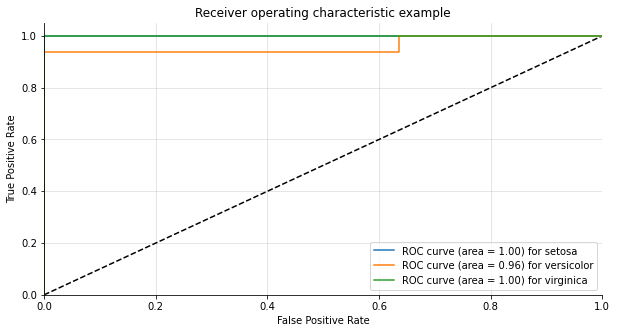

In [38]:
plot_multiclass_roc(clf_svm, X_test_scaled, y_test, n_classes=3, figsize=(10, 5))

# Save Model

In [39]:
svm_model_filename = 'model/iris_svm_model.sav'

In [40]:
std_scalar_filename = 'model/std_scalar_obj.sav'

In [41]:
joblib.dump(clf_svm, svm_model_filename)
joblib.dump(scale_obj, std_scalar_filename)

['model/std_scalar_obj.sav']

I am saving two models, one is for SVC and another is for scaling. Because i applied normlization on X before traing the model so i also need to perform this scaling on y values before calling .predict

# conclusion

So i finally finished this ML model for iris dataset. This is my first ML project.

Thank You 🙏